_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [1]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [118]:
def wrangle(df):
    X = df.copy()
    
    #add relational data
    X = X.merge(store, how = 'left')
    
    #make column names lower case
    X.columns = X.columns.str.lower()
    
    
    #convert to datetime objects and add date features
    X['date'] = pd.to_datetime(X.date)
    X['month'] = X.date.dt.month
    X['year'] = X.date.dt.year
    X['dayofyear'] = X.date.dt.dayofyear
    X = X.drop(columns = 'date')
    
    #add flue season feature
    X['flu_season'] = np.where((X.month > 8) | (X.month < 3), 1, 0)
    
    #fill missing values with zero, since they are dates or time periods
    X = X.fillna(value = 0)
    
    
    return X

In [119]:
import numpy as np
#instantiate target label
target = 'sales'

#get X matrix from wrangled data
X_train = wrangle(train)
X_test = wrangle(test)

#pop target vectors from X matrix and transform 
y_train = X_train.pop(target)
y_train_log = np.log1p(y_train)

y_test = X_test.pop(target)
y_test_log = np.log1p(y_test)

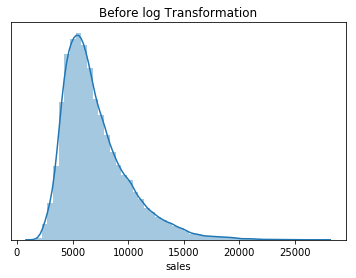

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#plot before transformation distribution
fig = plt.figure()

ax = sns.distplot(y_train)
ax.set_title('Before log Transformation')
ax.set_yticks([])
plt.show();

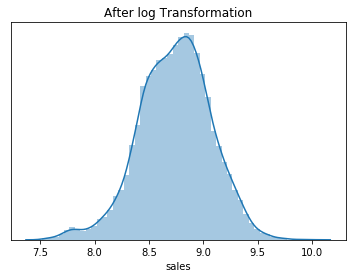

In [79]:
#plot after transformation distribution
fig = plt.figure()

ax = sns.distplot(y_val_log)
ax.set_title('After log Transformation')
ax.set_yticks([])
plt.show();

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [120]:
from sklearn.model_selection import train_test_split

#get unique store ids
stores= train['Store'].unique()

#split unique store ids for validation
X_train_stores, X_val_stores = train_test_split(stores,
                                                test_size = .2,
                                                random_state = 42)

#create train and validation matrix using unique store ids
X_train = wrangle(train[train.Store.isin(X_train_stores)])
X_val = wrangle(train[train.Store.isin(X_val_stores)])

In [121]:
#pop target vectors from train and validation matrices
y_train = X_train.pop(target)
y_train_log = np.log1p(y_train)

y_val = X_val.pop(target)
y_val_log  = np.log1p(y_val)

In [49]:
from sklearn.metrics import mean_squared_error

#root mean square will be our metric for this data
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [122]:
import category_encoders as ce
from xgboost import XGBRegressor

#encode data before fitting model
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

#store an eval set for early stopping
eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

#instantiate a warm model with some basic parameters
model = XGBRegressor(n_estimators = 1000,
                    max_depth = 4,
                    n_jobs = 3)

#fit 
model.fit(X_train_encoded,
          y_train_log,
          eval_set = eval_set,
          eval_metric = 'rmse',
          early_stopping_rounds = 10)

[23:48:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.46951	validation_1-rmse:7.4167
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:6.72312	validation_1-rmse:6.67246
[2]	validation_0-rmse:6.05139	validation_1-rmse:6.0036
[3]	validation_0-rmse:5.44685	validation_1-rmse:5.40114
[4]	validation_0-rmse:4.90278	validation_1-rmse:4.86049
[5]	validation_0-rmse:4.41313	validation_1-rmse:4.37324
[6]	validation_0-rmse:3.97248	validation_1-rmse:3.93602
[7]	validation_0-rmse:3.57591	validation_1-rmse:3.5414
[8]	validation_0-rmse:3.21902	validation_1-rmse:3.18603
[9]	validation_0-rmse:2.89787	validation_1-rmse:2.86706
[10]	validation_0-rmse:2.60887	validation_1-rmse:2.58019
[11]	validation_0-rmse:2.34882	validation_1-rmse:2.32279
[12]	validation_0-rmse:2.11479	validation_1-rmse:2.090

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=3, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [123]:
#get validation score
y_pred = model.predict(X_val_encoded)
print(f'Second Run Error = {rmse(y_val_log, y_pred):.4f}')

Second Run Error = 0.1581


In [60]:
#get test score
X_test_encoded = encoder.transform(X_test)
y_pred = model.predict(X_test_encoded)
print(f'Test Run Error = {rmse(y_test_log, y_pred):.4f}')

Test Run Error = 0.1477


In [124]:
from sklearn.model_selection import RandomizedSearchCV

#this will test more than 10 candidates
n_estimators = range(1000, 3000, 250)
max_depth = range(1,5)
learning_rate = [.1, .5, 1 , 2]

param_distributions = {
    'xgbregressor__n_estimators' : n_estimators,
    'xgbregressor__max_depth' : max_depth,
    'xgbregressor__learning_rate' : learning_rate,
    }

tuner = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions = param_distributions,
    n_iter = 10,
    cv = 4,
    return_train_score = True,
    n_jobs = 3)

In [126]:
tuner.fit(X_train_encoded, y_train_log)

[23:50:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=3,
          param_distributions={'xgbregressor__n_estimators': range(1000, 3000, 250), 'xgbregressor__max_depth': range(1, 5), 'xgbregressor__learning_rate': [0.1, 0.5, 1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [127]:
tuner.best_params_

{'xgbregressor__n_estimators': 2500,
 'xgbregressor__max_depth': 3,
 'xgbregressor__learning_rate': 1}

## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [133]:
import eli5
from eli5.sklearn import PermutationImportance

#customer scorer for use in permuter
def scoring(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return -rmse(y_true, y_pred)

#instantiate permuter with 5 iterations
permuter = PermutationImportance(model,
                                scoring = scoring,
                                cv = 'prefit',
                                n_iter = 5,
                                random_state = 42)

#fit 
permuter.fit(X_val_encoded, y_val_log)

#show weights based on feature names
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2858 ± 0.0031,customers
0.0269 ± 0.0013,promo
0.0114 ± 0.0004,storetype
0.0060 ± 0.0003,assortment
0.0060 ± 0.0001,promo2sinceweek
0.0044 ± 0.0001,dayofyear
0.0044 ± 0.0006,competitiondistance
0.0028 ± 0.0003,dayofweek
0.0016 ± 0.0003,year
0.0001 ± 0.0000,schoolholiday


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa16de4fba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa16de7aeb8>})

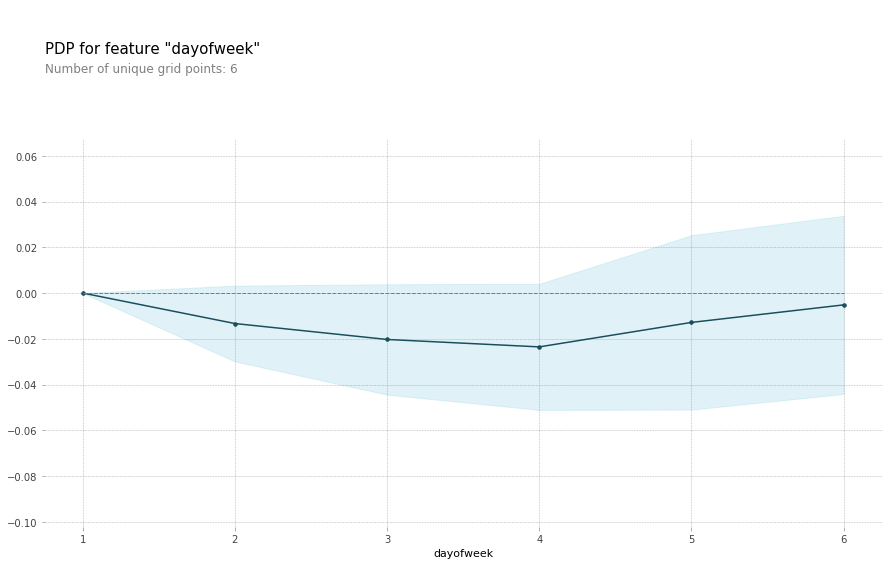

In [68]:
from pdpbox.pdp import pdp_isolate, pdp_plot

#show mid level features dependance
feature = 'dayofweek'

#instantiate and isolated variable
isolated = pdp_isolate(model = model,
                       dataset = X_val_encoded,
                       model_features = X_val_encoded.columns,
                       feature = feature)
#plot the variable
pdp_plot(isolated, feature_name = feature)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa16dcc82e8>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa16dc36dd8>})

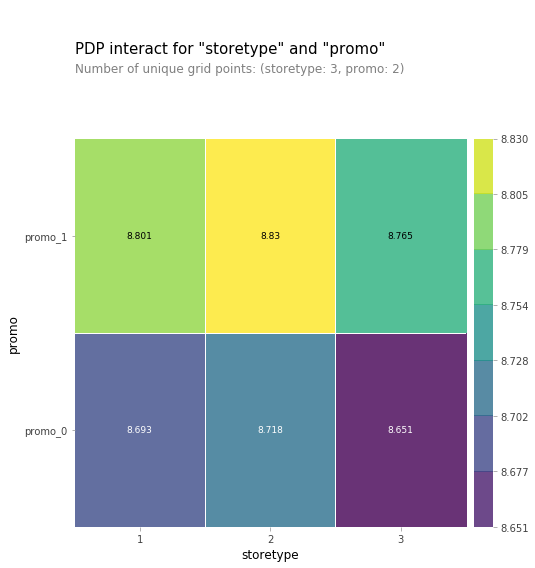

In [71]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

#check interaction of higher wieghted features
features = ['storetype', 'promo']

#instantiate interaction vairable
interaction = pdp_interact(model = model,
                           dataset = X_val_encoded,
                           model_features = X_val_encoded.columns,
                           features = features)
#plot interactions
pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)

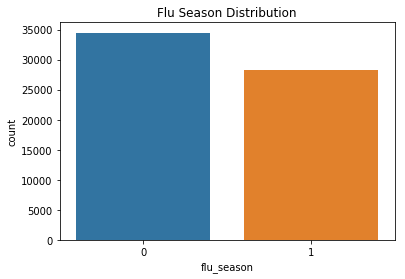

In [129]:
#plot before transformation distribution
fig = plt.figure()

ax = sns.countplot(X_train.flu_season)
ax.set_title('Flu Season Distribution')
plt.show();

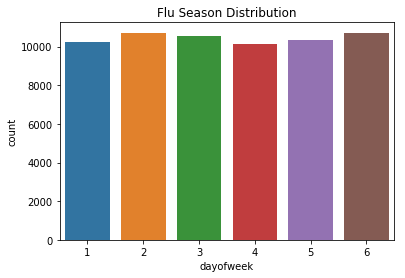

In [131]:
#plot before transformation distribution
fig = plt.figure()

ax = sns.countplot(X_train.dayofweek)
ax.set_title('Flu Season Distribution')
plt.show();

<bound method BaseEstimator.get_params of PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=3, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
           n_iter=5, random_state=42, refit=True,
           scoring=<function scoring at 0x7fa16dc1aea0>)>